* Get all positions within the 6 hour NOHRSC period
* Filter positions into d (5 or 10 km) equally spaced markers
* Divide into x (5?) equal bins
* Get max and mean snowfall for band at each bin
* Train model to predict bin location and the mean and max snowfall for each bin

In [72]:
import os
import math
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as col
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from metpy.plots import USCOUNTIES

In [73]:
# NOHRSC data directory
dataDir='/home/CarterHumphreys/bin/data/NOHRSC/'
dataDIR='/home/CarterHumphreys/research/les_neural_network/data/BAND_POSITION/'

# List of files
files = ['2019021406.nc']

In [74]:
def find_nthIndex(fullString, find, n):
    start = fullString.find(find)
    while start >= 0 and n > 1:
        start = fullString.find(find, start+len(find))
        n -= 1
    return start

# Rounds to nearest hour by adding a timedelta hour if minute >= 30
def roundTimeToNearestHour(t):
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)+timedelta(hours=t.minute//30))

def LinearInterpolation(x, x1, x2, y1, y2):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

# Returns distance between two lat/lon points in KM
def distanceBetweenPoints(lat1, lon1, lat2, lon2):
        theta = lon1 - lon2
        dist = math.sin(math.radians(lat1)) * math.sin(math.radians(lat2)) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(theta))
        dist = math.acos(dist)
        dist = math.degrees(dist)
        return (dist * 60) * 1.852 # 1 nm = 1.852 km

In [75]:
periodStart=datetime(2019, 2, 14, 0)
periodEnd=datetime(2019, 2, 14, 6)

# 5 km spacing from 0 km to 200 km
dataInterval=range(0, 205, 5) 
matrix=pd.DataFrame(columns=dataInterval)

for eventID in range(30, 37):
    eventDIR=f'{dataDIR}/Ontario_LES_Event{str(eventID).zfill(2)}'
    
    for dataFile in os.listdir(eventDIR):
        
        # Get file time
        time=dataFile[find_nthIndex(dataFile, '_', 2)+1:]
        time=datetime.strptime(time.replace('.csv',''), '%Y%m%d_%H%M%S')
        time=roundTimeToNearestHour(time)
        
        # Check if within period        
        if time >= periodStart and time <= periodEnd:
            
            # Read in band position data
            df = pd.read_csv(f'{eventDIR}/{dataFile}')
        
            bandStart={'Latitude':None, 'Longitude':None}
            bandData={}
        
            prevRow=None
            prevRowD=0
            for index, row in df.iterrows():

                # Set band initial position
                if bandStart['Latitude'] == None:
                    bandStart['Latitude'], bandStart['Longitude']=row['Latitude'], row['Longitude']
                    prevRow=row
                    
                # Interpolate band positions to 5km spacing
                else:           
                    d=distanceBetweenPoints(bandStart['Latitude'], bandStart['Longitude'], row['Latitude'], row['Longitude'])

                    for marker in dataInterval:
                        if marker >= prevRowD and marker <= d:
                            
                            midpointLat=LinearInterpolation(marker, prevRowD, d, prevRow['Latitude'], row['Latitude'])
                            midpointLat=round(midpointLat, 2)
                            midpointLon=LinearInterpolation(marker, prevRowD, d, prevRow['Longitude'], row['Longitude'])
                            midpointLon=round(midpointLon, 2)
                            
                            bandData.update({marker:f'{midpointLat},{midpointLon}'})

                            #print(f'{marker} km = {midpointLat}, {midpointLon}')

                    prevRow=row
                    prevRowD=d
            
            # Add to matrix of hourly band postions
            matrix=matrix.append(bandData, ignore_index=True)
            
matrix

/home/CarterHumphreys/.virtualenvs/research/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


,0,5,10,15,20,25,30,35,40,45,...,155,160,165,170,175,180,185,190,195,200
0,"43.61,-76.19","43.62,-76.13","43.62,-76.07","43.63,-76.01","43.64,-75.95","43.64,-75.89","43.64,-75.82","43.64,-75.76","43.65,-75.7","43.66,-75.64",...,"44.18,-74.43",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"43.6,-76.2","43.6,-76.14","43.6,-76.08","43.61,-76.01","43.62,-75.95","43.62,-75.89","43.63,-75.83","43.64,-75.77","43.64,-75.71","43.64,-75.64",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"43.46,-76.52","43.45,-76.46","43.44,-76.4","43.43,-76.33","43.42,-76.27","43.41,-76.21","43.41,-76.15","43.41,-76.09","43.41,-76.02","43.41,-75.96",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"43.52,-76.4","43.5,-76.35","43.48,-76.29","43.47,-76.22","43.47,-76.16","43.45,-76.1","43.44,-76.05","43.41,-75.99","43.39,-75.94","43.37,-75.88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"43.61,-76.19","43.6,-76.13","43.6,-76.07","43.6,-76.01","43.6,-75.95","43.6,-75.88","43.6,-75.82","43.61,-75.76","43.61,-75.7","43.61,-75.64",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"43.46,-76.51","43.46,-76.45","43.46,-76.39","43.45,-76.32","43.45,-76.26","43.45,-76.2","43.45,-76.14","43.44,-76.08","43.44,-76.01","43.44,-75.95",...,"43.57,-74.59","43.58,-74.53","43.58,-74.47","43.58,-74.41",NaN,NaN,NaN,NaN,NaN,NaN
6,"43.56,-76.2","43.55,-76.15","43.54,-76.08","43.54,-76.02","43.53,-75.96","43.53,-75.9","43.53,-75.83","43.53,-75.77","43.53,-75.71","43.53,-75.65",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


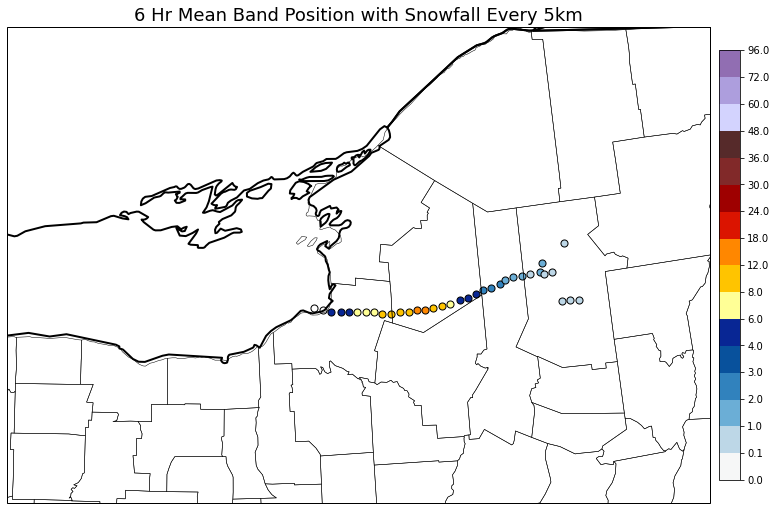

In [76]:
# Set plot extent
plotExtent = [-78.5, -73.5, 42.5, 45]

# Create the figure and an axes set to the projection
proj = ccrs.LambertConformal(central_longitude=((plotExtent[1]-plotExtent[0])/2+plotExtent[0]), central_latitude=((plotExtent[3]-plotExtent[2])/2+plotExtent[2]))
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(plotExtent)
    
# Add geographic features
state_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
ax.add_feature(state_borders, edgecolor='black', linewidth=2.0)
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.5)
            
# Get average band position and snowfall
for marker in matrix:
    data=matrix[marker].values
    
    latSum=0
    lonSum=0
    numPoints=0.0
    for point in data:
        try:
            latlon=point.split(',')
            
            latSum+=float(latlon[0])
            lonSum+=float(latlon[1])
            numPoints+=1
        except:
            continue
            
    if numPoints > 0:
        avgLat=round(latSum/numPoints, 2)
        avgLon=round(lonSum/numPoints, 2)
 
        for file in files:
            # Open file
            data = xr.open_dataset(f'{dataDir}/{file}')

            # Extract point values
            pointVal = data.sel(lat=avgLat, lon=avgLon, method='nearest')
            
            # Convert from mm to inches
            snowfall = round(pointVal.Data.values*(1/25.4)*1000, 1)
            
            clevs = [0.0, 0.1, 1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0, 18.0, 24.0, 30.0, 36.0, 48.0, 60.0, 72.0, 96.0]
            cmap = col.ListedColormap(['#f6f7f7', '#bdd7e7','#6baed6','#3182bd','#08519c','#082694','#ffff96','#ffc400','#ff8700','#db1400','#9e0000','#812929','#562a2a', '#d3d3fe','#ad9edd','#916eb2'])
            norm = col.BoundaryNorm(clevs, cmap.N)
            scatter = ax.scatter(avgLon, avgLat, c=snowfall, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), edgecolors='k', marker='o', s=50)
                     
# Set a title and show the plot
plt.colorbar(scatter, shrink=0.79,pad=0.01,ticks=clevs)
ax.set_title('6 Hr Mean Band Position with Snowfall Every 5km', loc='Center', fontSize=18)
plt.show()